In [15]:
import csv
import cv2
import copy
import itertools
import matplotlib as plot

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [16]:
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode= True ,
    max_num_hands= 1,
    min_detection_confidence=0.7,
)

# file = '/content/drive/MyDrive/asl_alphabet/test'
# image = cv2.flip(cv2.imread(file + '/B/B1.jpg'), 1)
# idx = 2

# results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))



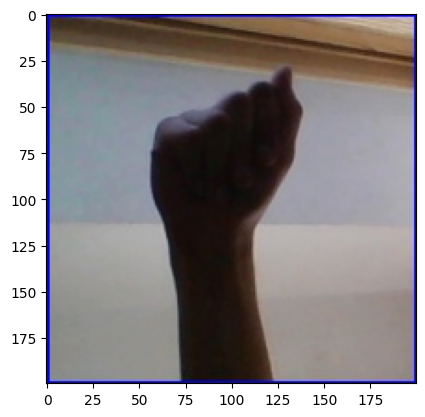

In [17]:
from PIL import Image
temp = Image.open('F:/hand-gesture-recognition-mediapipe/dataset/asl_alphabet_train/asl_alphabet_train/A/A1.jpg')

plot.pyplot.imshow(temp)
plot.pyplot.show()

In [18]:
def calc_landmark_list(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_point = []

    # Keypoint
    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        # landmark_z = landmark.z

        landmark_point.append([landmark_x, landmark_y])

    return landmark_point

def pre_process_landmark(landmark_list):
  temp_landmark_list = copy.deepcopy(landmark_list)

  # Convert to relative coordinates
  base_x, base_y = 0, 0
  for index, landmark_point in enumerate(temp_landmark_list):
      if index == 0:
          base_x, base_y = landmark_point[0], landmark_point[1]

      temp_landmark_list[index][0] = temp_landmark_list[index][0] - base_x
      temp_landmark_list[index][1] = temp_landmark_list[index][1] - base_y

  # Convert to a one-dimensional list
  temp_landmark_list = list(
      itertools.chain.from_iterable(temp_landmark_list))

  # Normalization
  max_value = max(list(map(abs, temp_landmark_list)))

  def normalize_(n):
      return n / max_value

  temp_landmark_list = list(map(normalize_, temp_landmark_list))

  return temp_landmark_list

def logging_csv(number, landmark_list):
  csv_path = 'F:/hand-gesture-recognition-mediapipe/dataset/model1/keypoint.csv'
  with open(csv_path, 'a', newline="") as f:
    writer = csv.writer(f)
    writer.writerow([number, *landmark_list])


In [22]:
#Reading image files and classifying them
ltr2num = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'J':9,
           'K':10, 'L':11, 'M':12, 'N':13, 'O':14, 'P':15, 'Q':16, 'R':17, 
           'S':18, 'T':19, 'U':20, 'V':21, 'W':22, 'X':23, 'Y':24, 'Z':25,
           'del':26, 'space':27}
num2ltr =  {value: key for key, value in ltr2num.items()}

file = 'F:/hand-gesture-recognition-mediapipe/dataset/asl_alphabet_train/asl_alphabet_train'
for ltr, num in ltr2num.items():
  print(ltr + 'started')
  for i in range(1, 3001):
    if i % 100 == 0:
      print(ltr + ':' + str(i) + 's started')

    img = cv2.flip(cv2.imread(file + '/' + ltr + '/' + ltr + str(i) +'.jpg'), 1)
    debug_image = copy.deepcopy(img)

    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    image.flags.writeable = False
    results = hands.process(image)
    image.flags.writeable = True

    if results.multi_hand_landmarks is not None:
      for hand_landmarks, handedness in zip(results.multi_hand_landmarks,
                                                  results.multi_handedness):
        
        landmark_list = calc_landmark_list(debug_image, hand_landmarks)
        pre_processed_landmark_list = pre_process_landmark(landmark_list)
        logging_csv(num, pre_processed_landmark_list)
    
  print(ltr + 'Done')
        
        


Astarted
A:100s started
A:200s started
A:300s started
A:400s started
A:500s started
A:600s started
A:700s started
A:800s started
A:900s started
A:1000s started
A:1100s started
A:1200s started
A:1300s started
A:1400s started
A:1500s started
A:1600s started
A:1700s started
A:1800s started
A:1900s started
A:2000s started
A:2100s started
A:2200s started
A:2300s started
A:2400s started
A:2500s started
A:2600s started
A:2700s started
A:2800s started
A:2900s started
A:3000s started
ADone
Bstarted
B:100s started
B:200s started
B:300s started
B:400s started
B:500s started
B:600s started
B:700s started
B:800s started
B:900s started
B:1000s started
B:1100s started
B:1200s started
B:1300s started
B:1400s started
B:1500s started
B:1600s started
B:1700s started
B:1800s started
B:1900s started
B:2000s started
B:2100s started
B:2200s started
B:2300s started
B:2400s started
B:2500s started
B:2600s started
B:2700s started
B:2800s started
B:2900s started
B:3000s started
BDone
Cstarted
C:100s started
C:20

# Specify each path

In [23]:
dataset = 'F:/hand-gesture-recognition-mediapipe/dataset/model1/keypoint.csv'
model_save_path = 'F:/hand-gesture-recognition-mediapipe/dataset/model1/keypoint_classifier.hdf5'
tflite_save_path = 'F:/hand-gesture-recognition-mediapipe/dataset/model1/keypoint_classifier.tflite'

# Set number of classes

In [26]:
NUM_CLASSES = 28

# Dataset reading

In [27]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [28]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [30]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [31]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 28)                308       
                                                                 
Total params: 1,378
Trainable params: 1,378
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [33]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [34]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
337/350 [===========================>..] - ETA: 0s - loss: 2.9120 - accuracy: 0.1420
Epoch 1: saving model to F:/hand-gesture-recognition-mediapipe/dataset/model1\keypoint_classifier.hdf5
350/350 [==============================] - 3s 4ms/step - loss: 2.8906 - accuracy: 0.1464 - val_loss: 1.9541 - val_accuracy: 0.5255
Epoch 2/1000
342/350 [============================>.] - ETA: 0s - loss: 2.0024 - accuracy: 0.3231
Epoch 2: saving model to F:/hand-gesture-recognition-mediapipe/dataset/model1\keypoint_classifier.hdf5
350/350 [==============================] - 1s 4ms/step - loss: 1.9994 - accuracy: 0.3239 - val_loss: 1.3287 - val_accuracy: 0.7253
Epoch 3/1000
346/350 [============================>.] - ETA: 0s - loss: 1.6846 - accuracy: 0.4071
Epoch 3: saving model to F:/hand-gesture-recognition-mediapipe/dataset/model1\keypoint_classifier.hdf5
350/350 [==============================] - 2s 5ms/step - loss: 1.6836 - accuracy: 0.4074 - val_loss: 1.0754 - val_accuracy: 0.7973
Epoc

In [35]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

117/117 [==============================] - 0s 3ms/step - loss: 0.5232 - accuracy: 0.8370


In [36]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [37]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 77ms/step
[4.5820003e-04 3.9667659e-03 4.0922390e-05 2.0694945e-03 1.8989111e-03
 8.3733481e-05 1.8239022e-03 3.8002585e-03 7.1782079e-03 3.6765198e-04
 4.3900579e-02 3.4661972e-04 9.8954544e-05 9.8362025e-06 1.5526620e-04
 6.5902568e-04 2.5316689e-04 5.0947303e-01 2.4826487e-03 2.0923439e-04
 3.5735989e-01 4.0499974e-02 7.1396749e-03 1.3421897e-02 1.1524816e-05
 2.2128734e-03 4.4255718e-05 3.3505577e-05]
17


# Confusion matrix

467/467 [==============================] - 1s 2ms/step


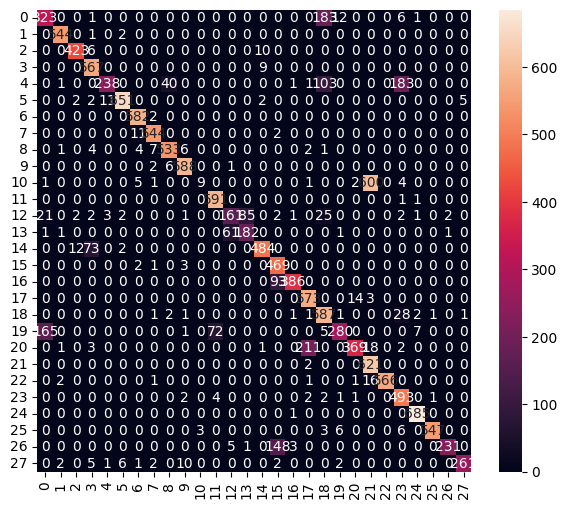

Classification Report
              precision    recall  f1-score   support

           0       0.63      0.61      0.62       526
           1       0.99      0.99      0.99       547
           2       0.96      0.96      0.96       439
           3       0.85      0.98      0.91       576
           4       0.94      0.42      0.58       567
           5       0.98      0.97      0.97       673
           6       0.96      1.00      0.98       584
           7       0.97      0.98      0.97       557
           8       0.92      0.96      0.94       558
           9       0.96      0.98      0.97       597
          10       0.75      0.01      0.03       623
          11       0.89      1.00      0.94       593
          12       0.71      0.52      0.60       310
          13       0.68      0.74      0.71       247
          14       0.96      0.85      0.90       571
          15       0.66      0.99      0.79       475
          16       0.98      0.81      0.89       479
     

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [41]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [42]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Public\Documents\Wondershare\CreatorTemp\tmpuujo5o73\assets


7600

# Inference test

In [43]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [44]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [45]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [46]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 1.55 ms


In [47]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[4.5819985e-04 3.9667659e-03 4.0922398e-05 2.0694938e-03 1.8989113e-03
 8.3733488e-05 1.8239024e-03 3.8002571e-03 7.1782111e-03 3.6765169e-04
 4.3900575e-02 3.4661908e-04 9.8954457e-05 9.8362034e-06 1.5526607e-04
 6.5902586e-04 2.5316677e-04 5.0947309e-01 2.4826464e-03 2.0923422e-04
 3.5735980e-01 4.0499985e-02 7.1396749e-03 1.3421892e-02 1.1524808e-05
 2.2128725e-03 4.4255677e-05 3.3505545e-05]
17
